In [1]:
#run time environment
import os

#aktuellen pfad auslesen wo dieses script liegt.


#path = r'C:\Users\minha\Desktop\Thesis\scripts\FH'#RB
mainpath = r'C:/Users/baatz/LDA_analysis/'
path=mainpath+'data_floodhydrology/'

#saving_path="C:/Users/minha/Desktop/plots_new/updated/"#RB
saving_path=path
os.chdir(path)

import pandas as pd
from gensim import matutils, models
import scipy.sparse
import matplotlib.pyplot as plt
import logging
import re
import os
import numpy as np
### choose the callbacks classes to import
from gensim.models.callbacks import PerplexityMetric, ConvergenceMetric, CoherenceMetric

In [2]:
#reading necessary inputs for lda from pickle
import pickle as pkl

with open('pickled_1907/data_lemmatized.pkl', 'rb') as f:
    data_lemmatized = pkl.load(f)
with open('pickled_1907/cleaned_corpus.pkl', 'rb') as f:
    corpus = pkl.load(f)
with open("pickled_1907/id2word.pkl", 'rb') as f:
    id2word= pkl.load(f)

In [3]:
logging.basicConfig(filename=f'pickled_1907/log_2507/lda_2019_new.log',
                        format="%(asctime)s:%(levelname)s:%(message)s",
                       level=logging.NOTSET)

In [4]:
# Set up the callbacks loggers
perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
convergence_logger = ConvergenceMetric(logger='shell')
coherence_cv_logger = CoherenceMetric(corpus=corpus, logger='shell', coherence = 'c_v', texts = data_lemmatized)

In [5]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
#from pathlib import Path
# List of the different iterations to try
#iterations = [10, 40, 70, 100]

max_topic_index=20 #subtracting -1 gives total number of topics

num_topics_array= np.array(list(range(2,max_topic_index,1)))
num_ntopics = len(num_topics_array)
np.save("pickled_1907/try_ntopics.npy",num_topics_array)

print(max_topic_index)
print("total number of topics are:")
print(num_ntopics+1)

# The number of passes to use - could change depending on requirements
passes = 50
iteration=100
# init storage
perplexity = {}
coherence = {}

print(num_topics_array)

20
total number of topics are:
19
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [6]:
from gensim.models import LdaModel

print("Start LDA processing")
for i,topics in enumerate(num_topics_array):
    #print(f'Start loop at iteration={i} with topics={topics} of total={num_ntopics} - Start')
    
    print(' ')
    lda_model_fname = f"pickled_1907/trained_models/trained_lda_model_{topics}.model"
    print(f'Filename: {lda_model_fname} - check if exists.')
    #print(' ')
    if not os.path.isfile(lda_model_fname):
        # Add text to logger to indicate new model
        print(f'File for {topics} does not exist. Run LDA.')
        
        logging.debug(f'Start of model: {topics} topics')
        
        # Create model - note callbacks argument uses list of created callback loggers
        lda_model = LdaMulticore(corpus=corpus,
                 id2word=id2word,
                 num_topics=topics,
                #            eval_every=20,
                chunksize=300,
                 passes=passes,
                 iterations=iteration,
                random_state=100,
                per_word_topics=True)
                #callbacks=[convergence_logger, perplexity_logger, coherence_cv_logger])
        
        print(f'Save: {lda_model_fname} .')
        lda_model.save(lda_model_fname)
        
    else:
        print(f'File for {topics} already exists. Skip modelling LDA and load LDA model')
        print(lda_model_fname)
        lda_model = LdaModel.load(lda_model_fname)
        
    print(f'Calculate perplexity.')
    perplexity[topics] = lda_model.log_perplexity(corpus)  # a measure of how good the model is. lower the better.
    
    print(f'Preplexity = {perplexity[topics]}')
    print(f'Calculate CoherenceModel.')
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence[topics] = coherence_model_lda.get_coherence()
    print(topics)
    print(f'Coherence = {coherence[topics]}')
    print('Move to next topic.')
    
    # Add text to logger to indicate end of this model
    logging.debug(f'End of model: {topics} topics')
    # screen report

print(lda_model)


Start LDA processing
 
Filename: pickled_1907/trained_models/trained_lda_model_2.model - check if exists.
File for 2 already exists. Skip modelling LDA and load LDA model
pickled_1907/trained_models/trained_lda_model_2.model
Calculate perplexity.
Preplexity = -7.436484437619449
Calculate CoherenceModel.
2
Coherence = 0.3370346916869684
Move to next topic.
 
Filename: pickled_1907/trained_models/trained_lda_model_3.model - check if exists.
File for 3 already exists. Skip modelling LDA and load LDA model
pickled_1907/trained_models/trained_lda_model_3.model
Calculate perplexity.
Preplexity = -7.393269917002026
Calculate CoherenceModel.
3
Coherence = 0.37394081686287034
Move to next topic.
 
Filename: pickled_1907/trained_models/trained_lda_model_4.model - check if exists.
File for 4 already exists. Skip modelling LDA and load LDA model
pickled_1907/trained_models/trained_lda_model_4.model
Calculate perplexity.
Preplexity = -7.379566559613467
Calculate CoherenceModel.
4
Coherence = 0.3858

In [7]:
print(num_topics_array)

with open("pickled_1907/trained_models/coherence.pkl", 'wb') as f:
    pkl.dump(coherence, f)  #save coherence
with open("pickled_1907/trained_models/perplexity.pkl", 'wb') as f:
    pkl.dump(perplexity, f) #save perplexity

##RB COmmented because not necessary - remove later
#with open("pickled_1907/trained_models/perplexity.pkl", 'rb') as f:
#    perplexity = pkl.load(f)
#with open("pickled_1907/trained_models/coherence.pkl", 'rb') as f:
#    coherence= pkl.load(f) 

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


saving file # Plot coherence and perplexity scores
saving file # Plot coherence and perplexity scores
saving file # Plot coherence and perplexity scores
saving file


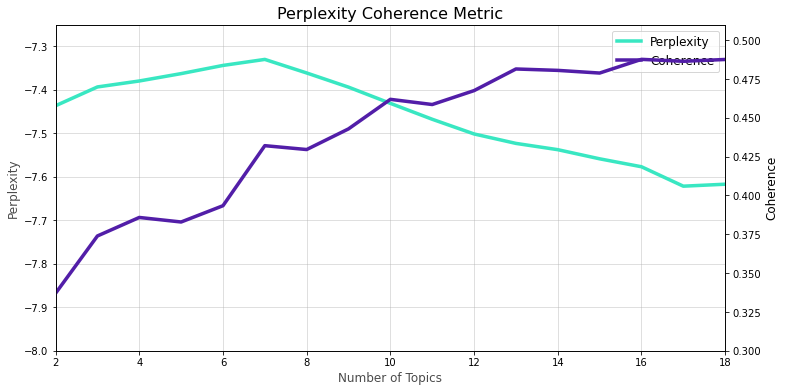

In [9]:
# Plot coherence and perplexity scores

print("saving file # Plot coherence and perplexity scores")

# grab colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# init figure
fig, ax = plt.subplots(figsize=(12,6))

print("saving file # Plot coherence and perplexity scores")

# plot perplexity
lists = sorted(perplexity.items())
x, y = zip(*lists) 
pltp = ax.plot(x, y, label='perplexity', linewidth=3.5,color="#39e7c2") 
plt.ylim(-8,-7.25)
plt.xlim(2,18)
# plot coherence
ax2 = ax.twinx() 
lists = sorted(coherence.items())
x, y = zip(*lists) 
pltc = ax2.plot(x, y, label='coherence', linewidth=3.5, color = "#521ea8")


print("saving file # Plot coherence and perplexity scores")

# axis labels
ax.set_xlabel('Number of Topics', fontsize=12,alpha=0.7)
ax.set_ylabel('Perplexity', fontsize=12,alpha=0.7)
ax2.set_ylabel('Coherence', fontsize=12)
ax.set_title('Perplexity Coherence Metric', fontsize=16)
ax.xaxis.set_tick_params(grid_alpha=0.5)
ax.yaxis.set_tick_params(grid_alpha=0.5)
plt.xlim(2,18)
plt.ylim(0.3,0.51)
# legend
ax.legend(pltp+pltc, ['Perplexity', 'Coherence'], fontsize=12, loc='best')

# aesthetics
ax.grid()
print("saving file")
plt.savefig(path+"plots/perplexity.jpg",dpi=300)

Comparing_Perplexity_of_HPC_and_PC
saving file
Comparing_coherence_of_HPC_and_PC
saving file


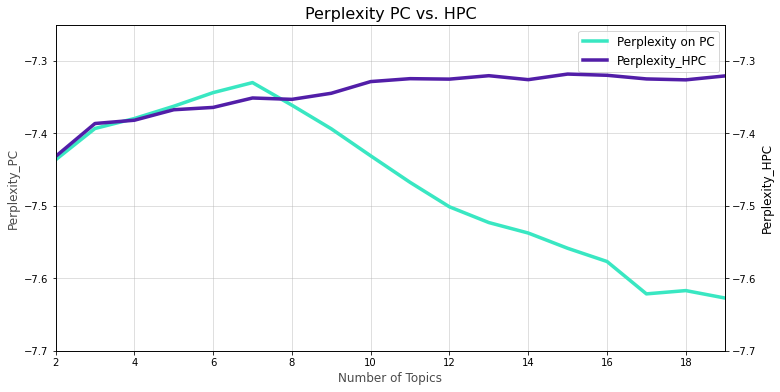

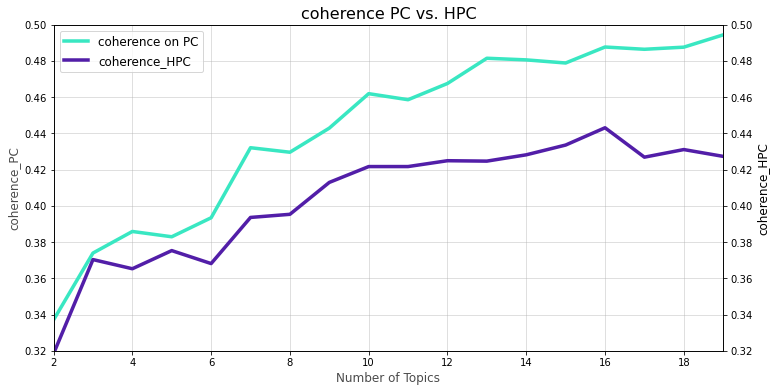

In [14]:

print("Comparing_Perplexity_of_HPC_and_PC")


with open("pickled_1907/trained_models/perplexity_HPC.pkl", 'rb') as f:
    perplexity_HPC = pkl.load(f)

# grab colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# init figure
fig, ax = plt.subplots(figsize=(12,6))


# plot perplexity
lists = sorted(perplexity.items())
x, y = zip(*lists) 
pltp = ax.plot(x, y, label='perplexity PC', linewidth=3.5,color="#39e7c2") 
plt.ylim(-7.7,-7.25)
plt.xlim(2,19)


ax2 = ax.twinx() 
lists = sorted(perplexity_HPC.items())
x, y = zip(*lists) 
pltc = ax2.plot(x, y, label='perplexity HPC', linewidth=3.5, color = "#521ea8")
plt.ylim(-7.7,-7.25)
plt.xlim(2,19)


# axis labels
ax.set_xlabel('Number of Topics', fontsize=12,alpha=0.7)
ax.set_ylabel('Perplexity_PC', fontsize=12,alpha=0.7)
ax2.set_ylabel('Perplexity_HPC', fontsize=12)
ax.set_title('Perplexity PC vs. HPC', fontsize=16)
ax.xaxis.set_tick_params(grid_alpha=0.5)
ax.yaxis.set_tick_params(grid_alpha=0.5)
# legend
ax.legend(pltp+pltc, ['Perplexity on PC', 'Perplexity_HPC'], fontsize=12, loc='best')

# aesthetics
ax.grid()
print("saving file")
plt.savefig(path+"plots/perplexity_PC-vs-HPC.jpg",dpi=300)





print("Comparing_coherence_of_HPC_and_PC")

with open("pickled_1907/trained_models/coherence_HPC.pkl", 'rb') as f:
    coherence_HPC = pkl.load(f)

# grab colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# init figure
fig, ax = plt.subplots(figsize=(12,6))


# plot coherence
lists = sorted(coherence.items())
x, y = zip(*lists) 
pltp = ax.plot(x, y, label='coherence PC', linewidth=3.5,color="#39e7c2") 
plt.ylim(0.32,0.5)
plt.xlim(2,19)


ax2 = ax.twinx() 
lists = sorted(coherence_HPC.items())
x, y = zip(*lists) 
pltc = ax2.plot(x, y, label='coherence HPC', linewidth=3.5, color = "#521ea8")
plt.ylim(0.32,0.5)
plt.xlim(2,19)


# axis labels
ax.set_xlabel('Number of Topics', fontsize=12,alpha=0.7)
ax.set_ylabel('coherence_PC', fontsize=12,alpha=0.7)
ax2.set_ylabel('coherence_HPC', fontsize=12)
ax.set_title('coherence PC vs. HPC', fontsize=16)
ax.xaxis.set_tick_params(grid_alpha=0.5)
ax.yaxis.set_tick_params(grid_alpha=0.5)
# legend
ax.legend(pltp+pltc, ['coherence on PC', 'coherence_HPC'], fontsize=12, loc='best')

# aesthetics
ax.grid()
print("saving file")
plt.savefig(path+"plots/coherence_PC-vs-HPC.jpg",dpi=300)